# **CARGA DE DATOS Y DE LIBRERÍAS**

In [1]:
from google.colab import drive
import os
import shutil
from zipfile import ZipFile
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix
import seaborn as sns
import glob
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
import random
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

In [2]:
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Ruta inicial en Google Drive
drive_root = '/content/drive/My Drive/'

# Función para encontrar la ruta completa de un archivo específico
def find_file_in_drive(filename, drive_root='/content/drive/My Drive/'):
    for root, dirs, files in os.walk(drive_root):
        if filename in files:
            return os.path.join(root, filename)
    return None

zip1_path = find_file_in_drive('Brain_Tumor_Synthetic (1).zip')
zip2_path = find_file_in_drive('Healthy_Synthetic (1).zip')

print('Ruta de Brain_Tumor_Synthetic.zip:', zip1_path)
print('Ruta de Healthy_Synthetic.zip:', zip2_path)


Ruta de Brain_Tumor_Synthetic.zip: /content/drive/My Drive/Brain_Tumor_Synthetic (1).zip
Ruta de Healthy_Synthetic.zip: /content/drive/My Drive/Healthy_Synthetic (1).zip


In [4]:
# Crear la carpeta Brain Images en /content si no existe
base_folder = '/content/Brain Sintetic Images'
os.makedirs(base_folder, exist_ok=True)

brain_tumor_folder = os.path.join(base_folder, 'Brain Tumor')
healthy_folder = os.path.join(base_folder, 'Healthy')

os.makedirs(brain_tumor_folder, exist_ok=True)
os.makedirs(healthy_folder, exist_ok=True)

zip1_path = '/content/drive/My Drive/Brain_Tumor_Synthetic (1).zip'
zip2_path = '/content/drive/My Drive/Healthy_Synthetic (1).zip'

shutil.copy(zip1_path, base_folder)
shutil.copy(zip2_path, base_folder)

with ZipFile(os.path.join(base_folder, 'Brain_Tumor_Synthetic (1).zip'), 'r') as zip_ref:
    zip_ref.extractall(brain_tumor_folder)

with ZipFile(os.path.join(base_folder, 'Healthy_Synthetic (1).zip'), 'r') as zip_ref:
    zip_ref.extractall(healthy_folder)

os.remove(os.path.join(base_folder, 'Brain_Tumor_Synthetic (1).zip'))
os.remove(os.path.join(base_folder, 'Healthy_Synthetic (1).zip'))

print(f'Imágenes de tumor cerebral extraídas en: {brain_tumor_folder}')
print(f'Imágenes saludables extraídas en: {healthy_folder}')

Imágenes de tumor cerebral extraídas en: /content/Brain Sintetic Images/Brain Tumor
Imágenes saludables extraídas en: /content/Brain Sintetic Images/Healthy


# **PROCESAMIENTO DE LOS DATOS**

In [5]:
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (64, 64))
            images.append(img)
            labels.append(label)
    return images, labels

# Rutas a los datasets
tumor_path = '/content/Brain Sintetic Images/Brain Tumor'
non_tumor_path = '/content/Brain Sintetic Images/Healthy'

In [6]:
base_dir = '/content/Brain Sintetic Images'

In [7]:
# Cargar imágenes y etiquetas de cada categoría
tumor_images, tumor_labels = load_images_from_folder(tumor_path, 1) 
non_tumor_images, non_tumor_labels = load_images_from_folder(non_tumor_path, 0)  

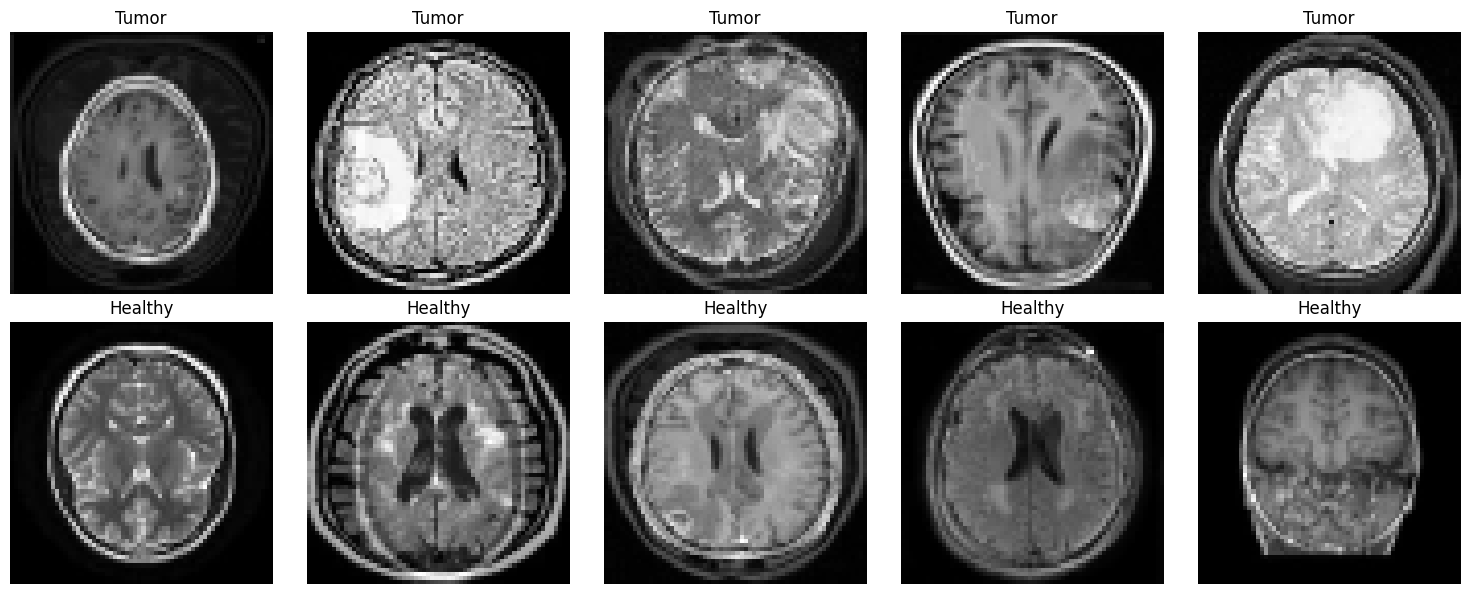

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

if len(tumor_images) < 5 or len(non_tumor_images) < 5:
    raise ValueError("Not enough images loaded for displaying.")

for i in range(5):
    ax = axes[0, i]
    ax.imshow(tumor_images[i], cmap='gray')
    ax.set_title('Tumor')
    ax.axis('off')

for i in range(5):
    ax = axes[1, i]
    ax.imshow(non_tumor_images[i], cmap='gray')
    ax.set_title('Healthy')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
# Combinar datasets
images = np.array(tumor_images + non_tumor_images)
labels = np.array(tumor_labels + non_tumor_labels)

images = images / 255.0

images = images.reshape(-1, 64, 64, 1)

In [10]:
# Dividir el dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [11]:
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# **MODELO CNN PARA DATASET SINTÉTICO**

In [12]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [13]:
model = Sequential([
    Input(shape=(64,64,3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [14]:

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=30,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Epoch 1/30
500/500 [==============================] - 36s 59ms/step - loss: 0.6517 - accuracy: 0.6113 - val_loss: 0.5483 - val_accuracy: 0.7165
Epoch 2/30
500/500 [==============================] - 23s 45ms/step - loss: 0.5553 - accuracy: 0.7191 - val_loss: 0.4809 - val_accuracy: 0.7778
Epoch 3/30
500/500 [==============================] - 26s 53ms/step - loss: 0.4758 - accuracy: 0.7719 - val_loss: 0.3348 - val_accuracy: 0.8662
Epoch 4/30
500/500 [==============================] - 25s 49ms/step - loss: 0.3918 - accuracy: 0.8221 - val_loss: 0.2620 - val_accuracy: 0.9030
Epoch 5/30
500/500 [==============================] - 24s 47ms/step - loss: 0.3251 - accuracy: 0.8624 - val_loss: 0.2057 - val_accuracy: 0.9250
Epoch 6/30
500/500 [==============================] - 23s 47ms/step - loss: 0.2839 - accuracy: 0.8821 - val_loss: 0.1849 - val_accuracy: 0.9333
Epoch 7/30
500/500 [==============================] - 26s 53ms/step - loss: 0.2537 - accuracy: 0.8982 - val_loss: 0.1882 - val_accuracy:

In [15]:
# Imprimir el accuracy y el loss finales
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Loss en los datos de prueba:", loss)
print("Precisión en los datos de prueba:", accuracy)

Loss en los datos de prueba: 0.09243092685937881
Precisión en los datos de prueba: 0.96875


In [16]:
hist_=pd.DataFrame(history.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.651715,0.611313,0.548313,0.71650
1,0.555345,0.719063,0.480889,0.77775
2,0.475811,0.771875,0.334772,0.86625
3,0.391804,0.822062,0.261995,0.90300
4,0.325053,0.862437,0.205704,0.92500
5,0.283902,0.882125,0.184915,0.93325
6,0.253673,0.898250,0.188182,0.92450
7,0.225304,0.908938,0.141123,0.94950
8,0.207479,0.917313,0.108799,0.96325
9,0.196175,0.924187,0.114421,0.96000


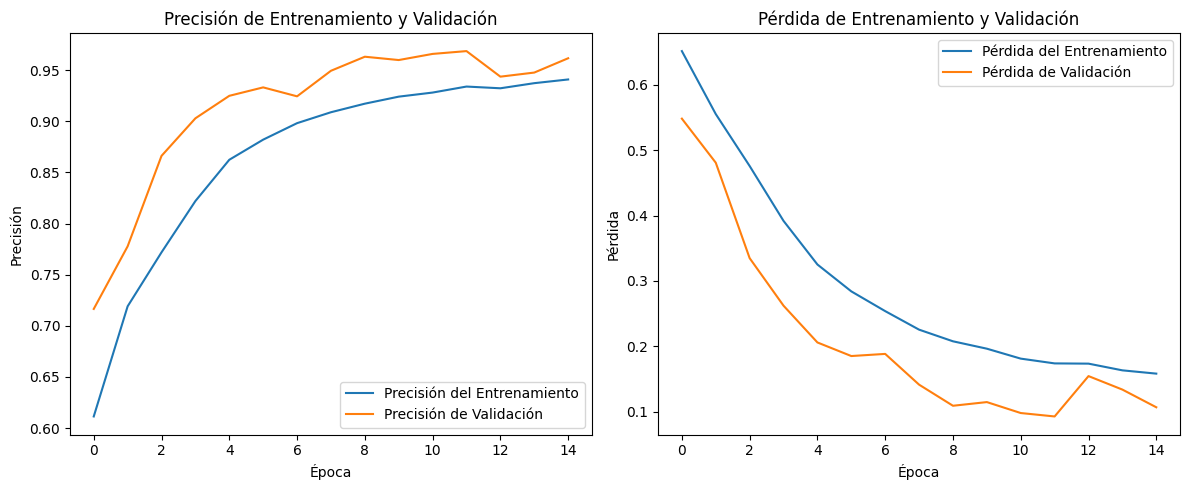

In [17]:
# Gráfico de precisión y pérdida durante el entrenamiento y la validación
plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión del Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión de Entrenamiento y Validación')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida del Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
# Realizar predicciones con salida detallada
y_pred_prob = model.predict(X_test, verbose=1)

y_pred = (y_pred_prob > 0.5).astype(int)

results = pd.DataFrame({
    'Etiqueta Actual': y_test.flatten(), 
    'Etiqueta Predicha': y_pred.flatten()
})

results['Etiqueta Actual'] = results['Etiqueta Actual'].map({0: 'Healthy', 1: 'Tumor'})
results['Etiqueta Predicha'] = results['Etiqueta Predicha'].map({0: 'Healthy', 1: 'Tumor'})

results

125/125 [==============================] - 0s 3ms/step


,Etiqueta Actual,Etiqueta Predicha
0,Healthy,Healthy
1,Tumor,Tumor
2,Tumor,Tumor
3,Tumor,Tumor
4,Healthy,Healthy
...,...,...
3995,Tumor,Tumor
3996,Tumor,Healthy
3997,Tumor,Tumor
3998,Tumor,Tumor


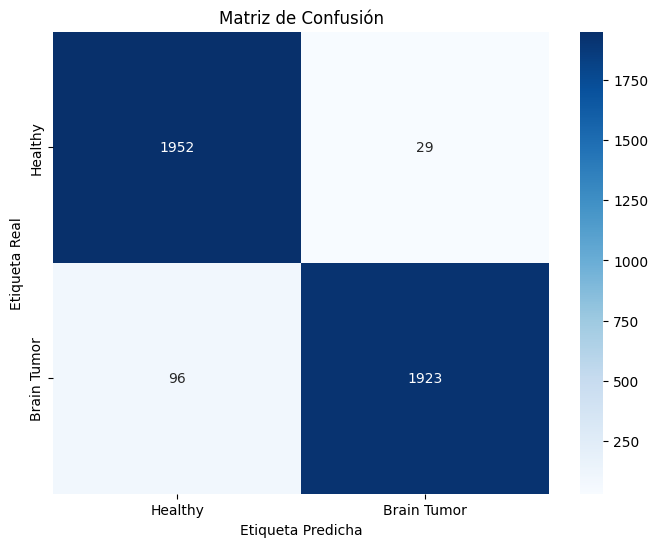

In [19]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Brain Tumor'], yticklabels=['Healthy', 'Brain Tumor'])
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.show()

In [20]:
# Generar el reporte de clasificación
report = classification_report(y_test, y_pred, target_names=['Healthy', 'Tumor'])
print(report)

              precision    recall  f1-score   support

     Healthy       0.95      0.99      0.97      1981
       Tumor       0.99      0.95      0.97      2019

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



In [21]:
# Rutas de las imágenes
image_paths = [
    '/content/PRUEBA GL.png',
    '/content/PRUEBA MEN.png',
    '/content/PRUEBA NO CANCER.png'
]

In [22]:
def prepare_image(image_path):
    """Prepara una imagen para ser evaluada por el modelo CNN."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, (64, 64))  
        img = img / 255.0  
        img = np.expand_dims(img, axis=-1) 
        img = np.repeat(img, 3, axis=-1)  
        img = np.expand_dims(img, axis=0)  
        return img
    else:
        return None

In [23]:
def predict_tumor_with_prob_model(image_path, model):
    """Determina si la imagen contiene un tumor y devuelve la probabilidad de la predicción."""
    img = prepare_image(image_path)
    if img is not None:
        prediction = model.predict(img)
        probability = prediction[0][0]
        return ("Tumor", probability) if probability > 0.5 else ("Healthy", 1 - probability)
    else:
        return ("La imagen no se encontró o no pudo leerse", None)


1/1 [==============================] - 0s 17ms/step


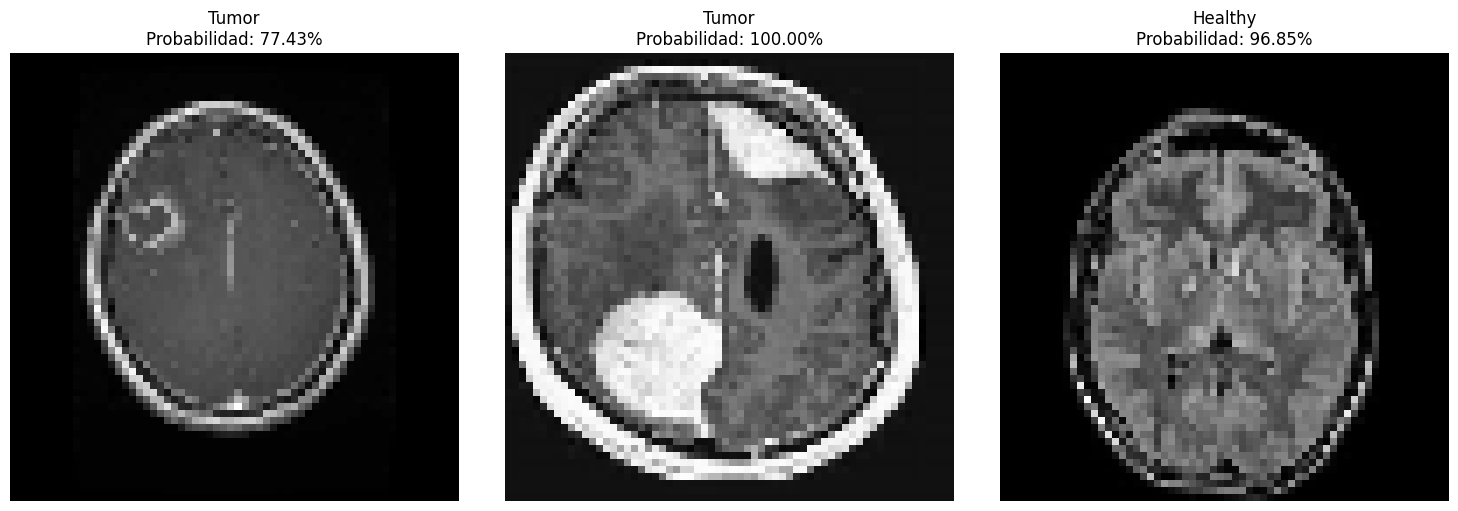

In [24]:
# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Procesar cada imagen y mostrar
for ax, image_path in zip(axes, image_paths):
    label, prob = predict_tumor_with_prob_model(image_path, model)
    if label != "La imagen no se encontró o no pudo leerse":
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (64, 64))
        ax.imshow(img, cmap='gray')
        ax.title.set_text(f'{label}\nProbabilidad: {prob:.2%}')
    else:
        ax.imshow(np.zeros((64, 64)), cmap='gray')
        ax.title.set_text(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [25]:
def plot_roc_curve(model, X_test, y_test):
    # Predecir probabilidades para el conjunto de prueba
    y_pred_probs = model.predict(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

    roc_auc = auc(fpr, tpr)

    # Graficar la Curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Característica Operativa del Receptor (ROC)')
    plt.legend(loc="lower right")
    plt.show()


125/125 [==============================] - 0s 2ms/step


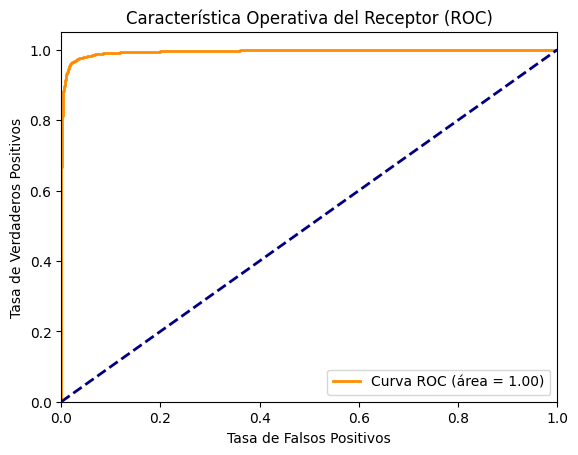

In [26]:
plot_roc_curve(model, X_test, y_test)

In [27]:
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)  
    if img is None:
        raise FileNotFoundError(f"Error al cargar la imagen: {image_path}")
    img = cv2.resize(img, (64, 64))  
    img = img / 255.0  
    img = np.expand_dims(img, axis=0) 
    return img

def get_gradcam(model, img_array, layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

def display_gradcam(img, heatmap, alpha=0.6):
    heatmap = cv2.resize(heatmap, (img.shape[2], img.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = heatmap * alpha + img[0, :, :, 0][:, :, np.newaxis] * 255
    superimposed_img = np.uint8(superimposed_img)
    return superimposed_img

In [28]:
print("Layers of Model 1:")
for layer in model.layers:
    print(layer.name)

Layers of Model 1:
conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
flatten
dense
dropout
dense_1


In [29]:
# Cargar la imagen
image_path = '/content/EJ GL.jpg'  
img_array = load_and_preprocess_image(image_path)
image_path2 = '/content/PRUEBA GL.png'  
img_array2 = load_and_preprocess_image(image_path2)

In [30]:
images = [(img_array, 'EJ GL.jpg'), (img_array2, 'PRUEBA GL.png')]

In [31]:
layer_names_model1 = ['conv2d', 'conv2d_1', 'conv2d_2']

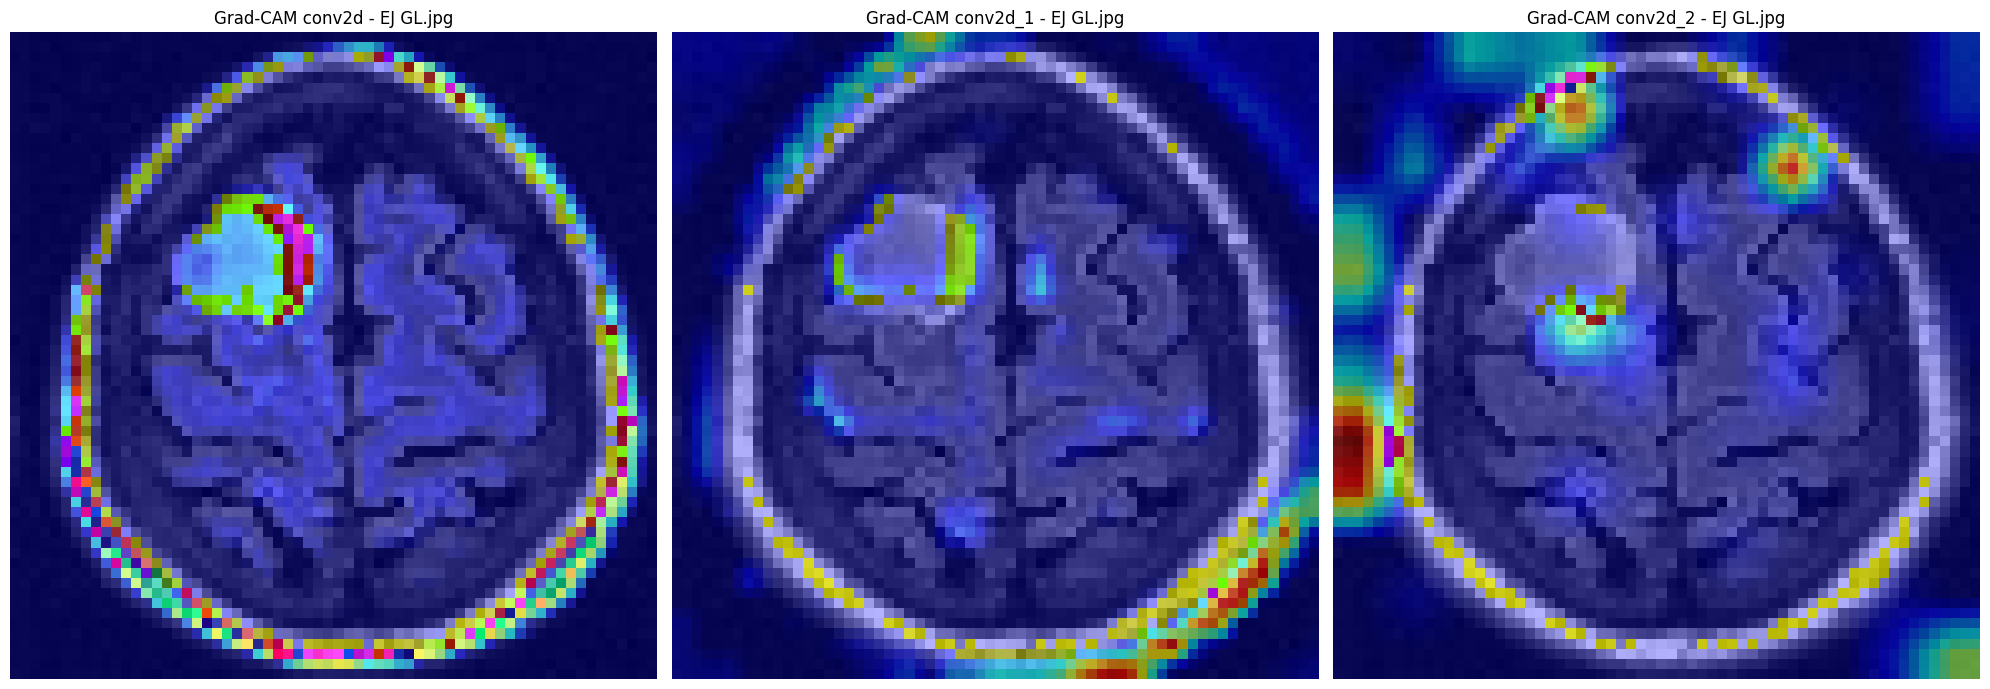

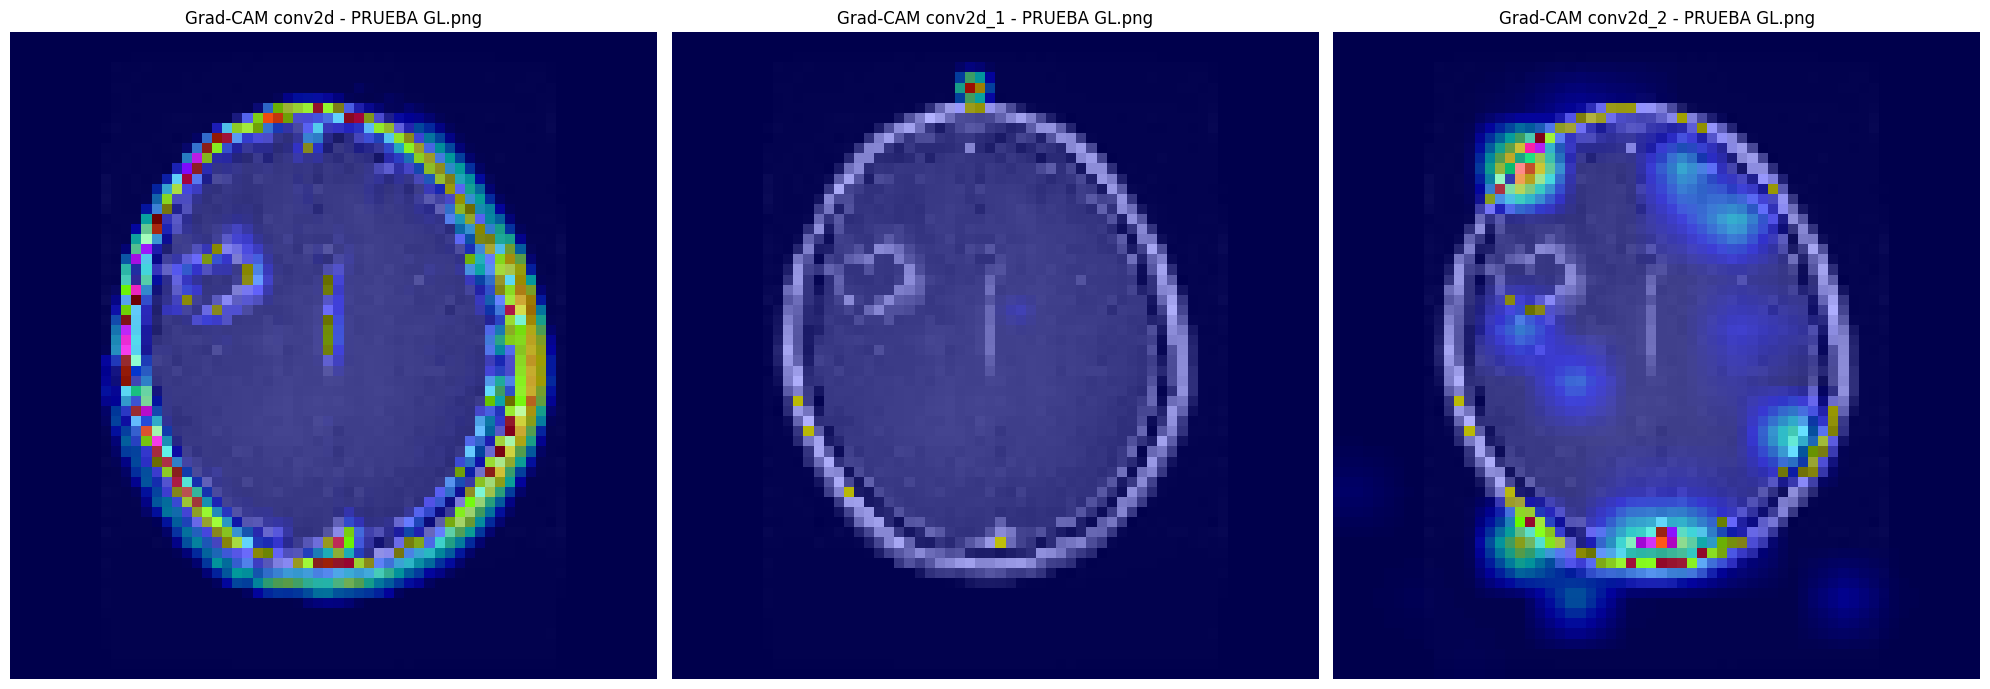

In [32]:
# Para Modelo 1
for img_array, img_name in images:
    plt.figure(figsize=(20, 10))
    for i, layer_name in enumerate(layer_names_model1):
        heatmap = get_gradcam(model, img_array, layer_name)
        superimposed_img = display_gradcam(img_array, heatmap)
        plt.subplot(1, len(layer_names_model1), i+1)
        plt.title(f'Grad-CAM {layer_name} - {img_name}')
        plt.imshow(superimposed_img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [33]:
def analyze_errors(model, X_test, y_test):
    # Obtener las probabilidades de las predicciones
    y_pred_prob = model.predict(X_test)
    
    y_pred = (y_pred_prob > 0.5).astype(int)

    
    results = pd.DataFrame({
        'Etiqueta Actual': y_test.flatten(),
        'Etiqueta Predicha': y_pred.flatten()
    })

    results['Etiqueta Actual'] = results['Etiqueta Actual'].map({0: 'Healthy', 1: 'Tumor'})
    results['Etiqueta Predicha'] = results['Etiqueta Predicha'].map({0: 'Healthy', 1: 'Tumor'})

    # Identificar predicciones incorrectas
    incorrect_predictions = results[results['Etiqueta Actual'] != results['Etiqueta Predicha']]

    # Mostrar resultados
    print("Número de predicciones incorrectas:", len(incorrect_predictions))
    print(incorrect_predictions)
    print("\n")

In [34]:
# Aplicar la función a cada modelo
print("Errores en Modelo 1:")
analyze_errors(model, X_test, y_test)

Errores en Modelo 1:
125/125 [==============================] - 0s 3ms/step
Número de predicciones incorrectas: 125
     Etiqueta Actual Etiqueta Predicha
11             Tumor           Healthy
20             Tumor           Healthy
78             Tumor           Healthy
141          Healthy             Tumor
155            Tumor           Healthy
...              ...               ...
3879           Tumor           Healthy
3931           Tumor           Healthy
3937         Healthy             Tumor
3984           Tumor           Healthy
3996           Tumor           Healthy

[125 rows x 2 columns]




# **MODELO CNN PREENTRENADO PARA DATASET SINTÉTICO**


In [ ]:
# Directorio original de las imágenes
original_data_dir = '/content/Brain Sintetic Images'

folders = os.listdir(original_data_dir)

val_split = 0.2
test_split = 0.1

split_data_dir = '/content/split_data'
os.makedirs(split_data_dir, exist_ok=True)

for folder in folders:
    folder_path = os.path.join(original_data_dir, folder)
    images = os.listdir(folder_path)

    random.shuffle(images)
    split_index_val = int(len(images) * (1 - val_split - test_split))
    split_index_test = int(len(images) * (1 - test_split))
    train_images = images[:split_index_val]
    val_images = images[split_index_val:split_index_test]
    test_images = images[split_index_test:]

    train_dir = os.path.join(split_data_dir, 'train', folder)
    val_dir = os.path.join(split_data_dir, 'val', folder)
    test_dir = os.path.join(split_data_dir, 'test', folder)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    
    for image in train_images:
        src = os.path.join(folder_path, image)
        dst = os.path.join(train_dir, image)
        shutil.copy(src, dst)

    for image in val_images:
        src = os.path.join(folder_path, image)
        dst = os.path.join(val_dir, image)
        shutil.copy(src, dst)

    for image in test_images:
        src = os.path.join(folder_path, image)
        dst = os.path.join(test_dir, image)
        shutil.copy(src, dst)

print("División completa.")

split_data_dir = '/content/split_data'


train_count = 0
val_count = 0
test_count = 0


for folder in ['train', 'val', 'test']:
    for subfolder in os.listdir(os.path.join(split_data_dir, folder)):
        folder_path = os.path.join(split_data_dir, folder, subfolder)
        num_images = len(os.listdir(folder_path))
        if folder == 'train':
            train_count += num_images
        elif folder == 'val':
            val_count += num_images
        else:
            test_count += num_images

print(f"El número total de imágenes en train es: {train_count}")
print(f"El número total de imágenes en val es: {val_count}")
print(f"El número total de imágenes en test es: {test_count}")


División completa.
El número total de imágenes en train es: 18197
El número total de imágenes en val es: 7168
El número total de imágenes en test es: 3793


In [ ]:
# Configuración de TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()  
print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [ ]:
# Definición de paths
split_data_dir = '/content/split_data'
train_dir = os.path.join(split_data_dir, 'train')
val_dir = os.path.join(split_data_dir, 'val')
test_dir = os.path.join(split_data_dir, 'test')

# Parámetros del modelo
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
EPOCHS = 12


In [ ]:
# Generadores de datos con aumento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 18197 images belonging to 2 classes.
Found 7168 images belonging to 2 classes.
Found 3793 images belonging to 2 classes.


In [ ]:
with strategy.scope():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
    ]
)

Epoch 1/12
1137/1137 [==============================] - 353s 299ms/step - loss: 0.5084 - accuracy: 0.7441 - val_loss: 0.3456 - val_accuracy: 0.8506 - lr: 0.0010
Epoch 2/12
1137/1137 [==============================] - 320s 281ms/step - loss: 0.4177 - accuracy: 0.8068 - val_loss: 0.3481 - val_accuracy: 0.8387 - lr: 0.0010
Epoch 3/12
1137/1137 [==============================] - 305s 268ms/step - loss: 0.3882 - accuracy: 0.8210 - val_loss: 0.2777 - val_accuracy: 0.8877 - lr: 0.0010
Epoch 4/12
1137/1137 [==============================] - 305s 268ms/step - loss: 0.3633 - accuracy: 0.8338 - val_loss: 0.2646 - val_accuracy: 0.8908 - lr: 0.0010
Epoch 5/12
1137/1137 [==============================] - 308s 271ms/step - loss: 0.3510 - accuracy: 0.8427 - val_loss: 0.2624 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 6/12
1137/1137 [==============================] - 309s 272ms/step - loss: 0.3386 - accuracy: 0.8465 - val_loss: 0.2352 - val_accuracy: 0.9033 - lr: 0.0010
Epoch 7/12
1137/1137 [============

In [ ]:
# Evaluar el modelo en los datos de prueba
loss, accuracy = model.evaluate(val_generator)
print("Loss en los datos de prueba:", loss)
print("Precisión en los datos de prueba:", accuracy)

448/448 [==============================] - 32s 71ms/step - loss: 0.1972 - accuracy: 0.9189
Loss en los datos de prueba: 0.19724930822849274
Precisión en los datos de prueba: 0.9189453125


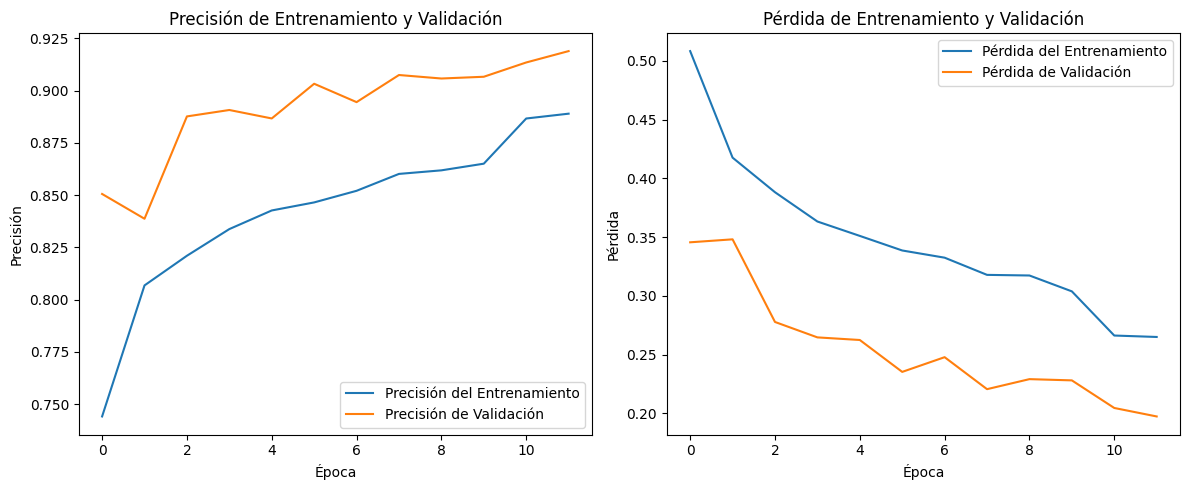

In [ ]:
# Gráfico de precisión y pérdida durante el entrenamiento y la validación
plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión del Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión de Entrenamiento y Validación')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida del Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Descongelar las capas superiores del modelo
for layer in model.layers[-10:]:
    layer.trainable = True

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Entrenar el modelo durante más épocas
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
    ]
)

Epoch 1/10
1137/1137 [==============================] - 318s 277ms/step - loss: 0.2586 - accuracy: 0.8981 - val_loss: 0.0708 - val_accuracy: 0.9727 - lr: 1.0000e-04
Epoch 2/10
1137/1137 [==============================] - 320s 282ms/step - loss: 0.0835 - accuracy: 0.9695 - val_loss: 0.0383 - val_accuracy: 0.9865 - lr: 1.0000e-04
Epoch 3/10
1137/1137 [==============================] - 313s 275ms/step - loss: 0.0570 - accuracy: 0.9803 - val_loss: 0.0332 - val_accuracy: 0.9879 - lr: 1.0000e-04
Epoch 4/10
1137/1137 [==============================] - 321s 282ms/step - loss: 0.0475 - accuracy: 0.9828 - val_loss: 0.0156 - val_accuracy: 0.9955 - lr: 1.0000e-04
Epoch 5/10
1137/1137 [==============================] - 315s 277ms/step - loss: 0.0346 - accuracy: 0.9878 - val_loss: 0.0124 - val_accuracy: 0.9946 - lr: 1.0000e-04
Epoch 6/10
1137/1137 [==============================] - 312s 274ms/step - loss: 0.0315 - accuracy: 0.9893 - val_loss: 0.0196 - val_accuracy: 0.9948 - lr: 1.0000e-04
Epoch 7/10

In [ ]:
# Evaluar el modelo en los datos de prueba
loss, accuracy = model.evaluate(val_generator)
print("Loss en los datos de prueba:", loss)
print("Precisión en los datos de prueba:", accuracy)

448/448 [==============================] - 43s 96ms/step - loss: 0.0043 - accuracy: 0.9986
Loss en los datos de prueba: 0.004292378667742014
Precisión en los datos de prueba: 0.9986048936843872


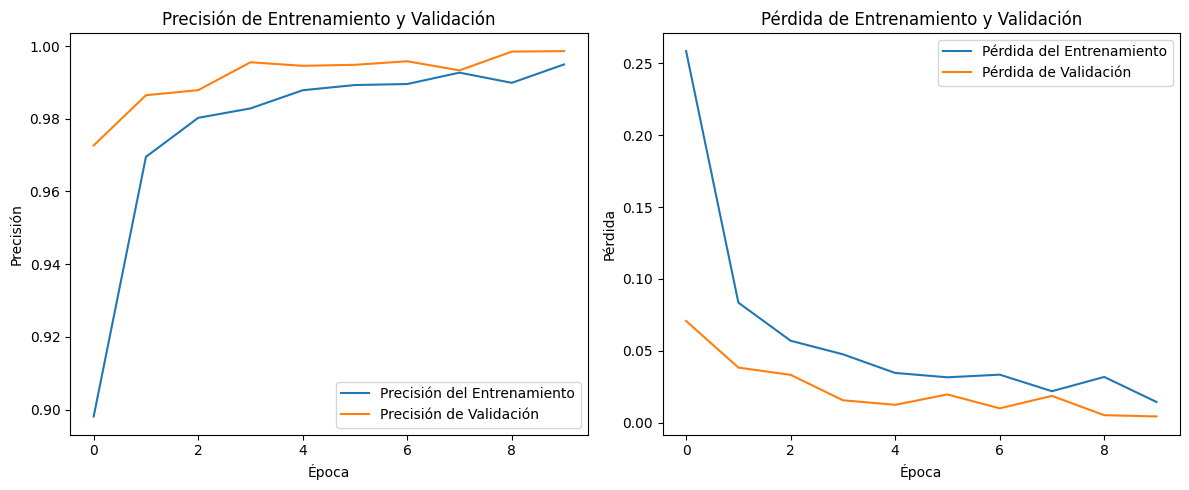

In [ ]:
# Gráfico de precisión y pérdida durante el entrenamiento y la validación
plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history_fine.history['accuracy'], label='Precisión del Entrenamiento')
plt.plot(history_fine.history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión de Entrenamiento y Validación')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history_fine.history['loss'], label='Pérdida del Entrenamiento')
plt.plot(history_fine.history['val_loss'], label='Pérdida de Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida de Entrenamiento y Validación')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Realizar predicciones en el conjunto de prueba
test_generator.reset()  # Asegúrate de reiniciar el generador antes de predecir
predictions = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

results = pd.DataFrame({
    'Filename': test_generator.filenames,
    'Clase Predicha': predicted_classes,
    'Clase Real': true_classes
})

results['Nombre Clase Predicha'] = results['Clase Predicha'].apply(lambda x: class_labels[x])
results['Nombre Clase Real'] = results['Clase Real'].apply(lambda x: class_labels[x])

# Mostrar las primeras filas de la tabla
results.head()

238/238 [==============================] - 19s 77ms/step


,Filename,Clase Predicha,Clase Real,Nombre Clase Predicha,Nombre Clase Real
0,Brain Tumor/Cancer (1009).png,0,0,Brain Tumor,Brain Tumor
1,Brain Tumor/Cancer (1013).png,0,0,Brain Tumor,Brain Tumor
2,Brain Tumor/Cancer (1020).png,0,0,Brain Tumor,Brain Tumor
3,Brain Tumor/Cancer (1021).png,0,0,Brain Tumor,Brain Tumor
4,Brain Tumor/Cancer (1028).png,0,0,Brain Tumor,Brain Tumor


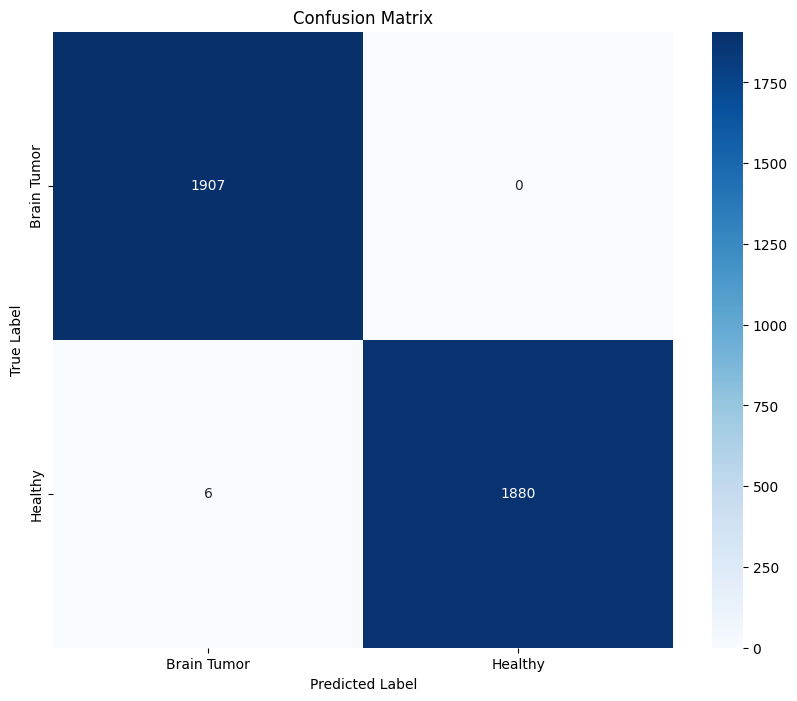

In [ ]:
# Generar la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

 Brain Tumor       1.00      1.00      1.00      1907
     Healthy       1.00      1.00      1.00      1886

    accuracy                           1.00      3793
   macro avg       1.00      1.00      1.00      3793
weighted avg       1.00      1.00      1.00      3793



In [ ]:
def prepare_image(image_path):
    """Prepara una imagen para ser evaluada por el modelo CNN."""
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is not None:
        img = cv2.resize(img, (224, 224))  
        img = img / 255.0 
        img = np.expand_dims(img, axis=-1)  
        img = np.expand_dims(img, axis=0)  
        return img
    else:
        return None

def predict_tumor_model1(image_path, model):
    """Determina si la imagen contiene un tumor utilizando el modelo CNN."""
    img = prepare_image(image_path)
    if img is not None:
        prediction = model.predict(img)
        return "Tumor" if prediction[0][0] > 0.5 else "Healthy"
    else:
        return "La imagen no se encontró o no pudo leerse"

def predict_tumor_with_prob_model1(image_path, model):
    """Determina si la imagen contiene un tumor y devuelve la probabilidad de la predicción."""
    img = prepare_image(image_path)
    if img is not None:
        prediction = model.predict(img)
        probability = prediction[0][0]
        return ("Tumor", probability) if probability > 0.5 else ("Healthy", 1 - probability)
    else:
        return ("La imagen no se encontró o no pudo leerse", None)

In [ ]:
image_paths = [
    '/content/PRUEBA GL.png',
    '/content/PRUEBA MEN.png',
    '/content/PRUEBA NO CANCER.png'
]

1/1 [==============================] - 0s 21ms/step


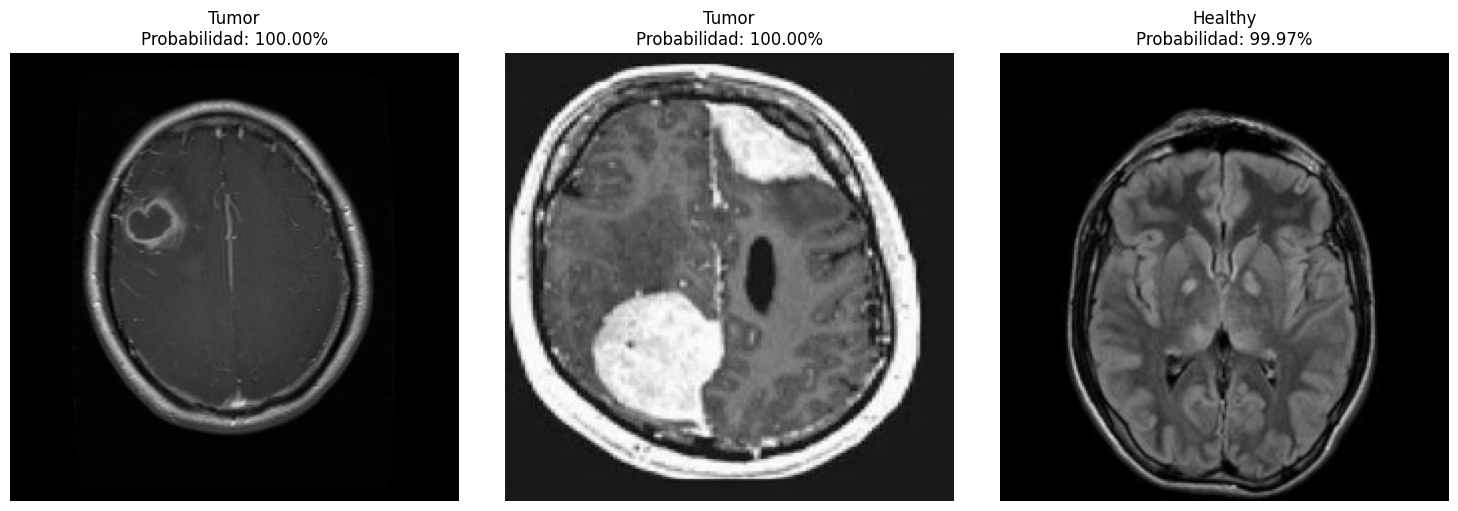

In [ ]:
# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Procesar cada imagen y mostrar
for ax, image_path in zip(axes, image_paths):
    label, prob = predict_tumor_with_prob_model1(image_path, model)
    if label != "La imagen no se encontró o no pudo leerse":
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224, 224))
        ax.imshow(img, cmap='gray')
        ax.title.set_text(f'{label}\nProbabilidad: {prob:.2%}')
    else:
        ax.imshow(np.zeros((224, 224)), cmap='gray')
        ax.title.set_text(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def plot_roc_curve(model, test_generator):
    # Predecir probabilidades para el conjunto de prueba
    test_generator.reset()  # Asegúrate de reiniciar el generador antes de predecir
    y_pred_probs = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

    y_test = test_generator.classes

    if y_test.ndim == 2 and y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

    y_pred_probs = y_pred_probs[:len(y_test)]

    # Calcular ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs[:, 1])  
    # Calcular AUC
    roc_auc = auc(fpr, tpr)

    # Graficar la Curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Característica Operativa del Receptor (ROC)')
    plt.legend(loc="lower right")
    plt.show()

238/238 [==============================] - 17s 73ms/step


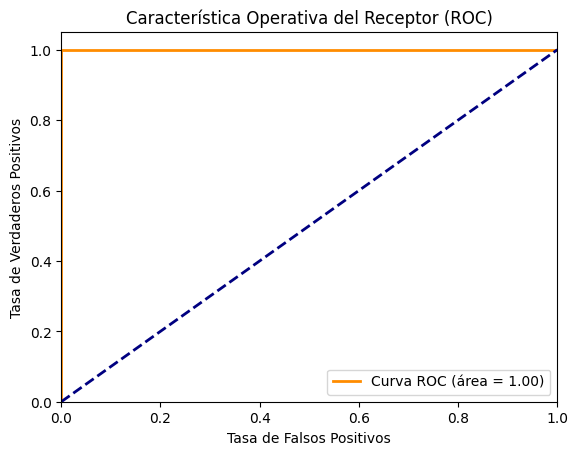

In [ ]:
plot_roc_curve(model, test_generator)

In [ ]:
print("Layers of Model Fine Tunning:")
for layer in model.layers:
    print(layer.name)

Layers of Model Fine Tunning:
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_average_pooling2d
dense
dropout
dense_1


In [ ]:
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)  
    if img is None:
        raise FileNotFoundError(f"Error al cargar la imagen: {image_path}")
    img = cv2.resize(img, (224, 224))  
    img = img / 255.0  
    img = np.expand_dims(img, axis=0)  
    return img

In [ ]:
# Definir la función Grad-CAM
def get_gradcam(model, img_array, layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

In [ ]:
# Función para visualizar Grad-CAM
def display_gradcam(img, heatmap, alpha=0.6):
    heatmap = cv2.resize(heatmap, (img.shape[2], img.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = heatmap * alpha + img[0, :, :, 0][:, :, np.newaxis] * 255
    superimposed_img = np.uint8(superimposed_img)
    return superimposed_img

In [ ]:
# Cargar la imagen
image_path = '/content/EJ GL.jpg'
img_array = load_and_preprocess_image(image_path)
image_path2 = '/content/PRUEBA GL.png'
img_array2 = load_and_preprocess_image(image_path2)

In [ ]:
images = [(img_array, 'EJ GL.jpg'), (img_array2, 'PRUEBA GL.png')]

In [ ]:
layer_names_model = ['block5_conv1', 'block5_conv2', 'block5_conv3']

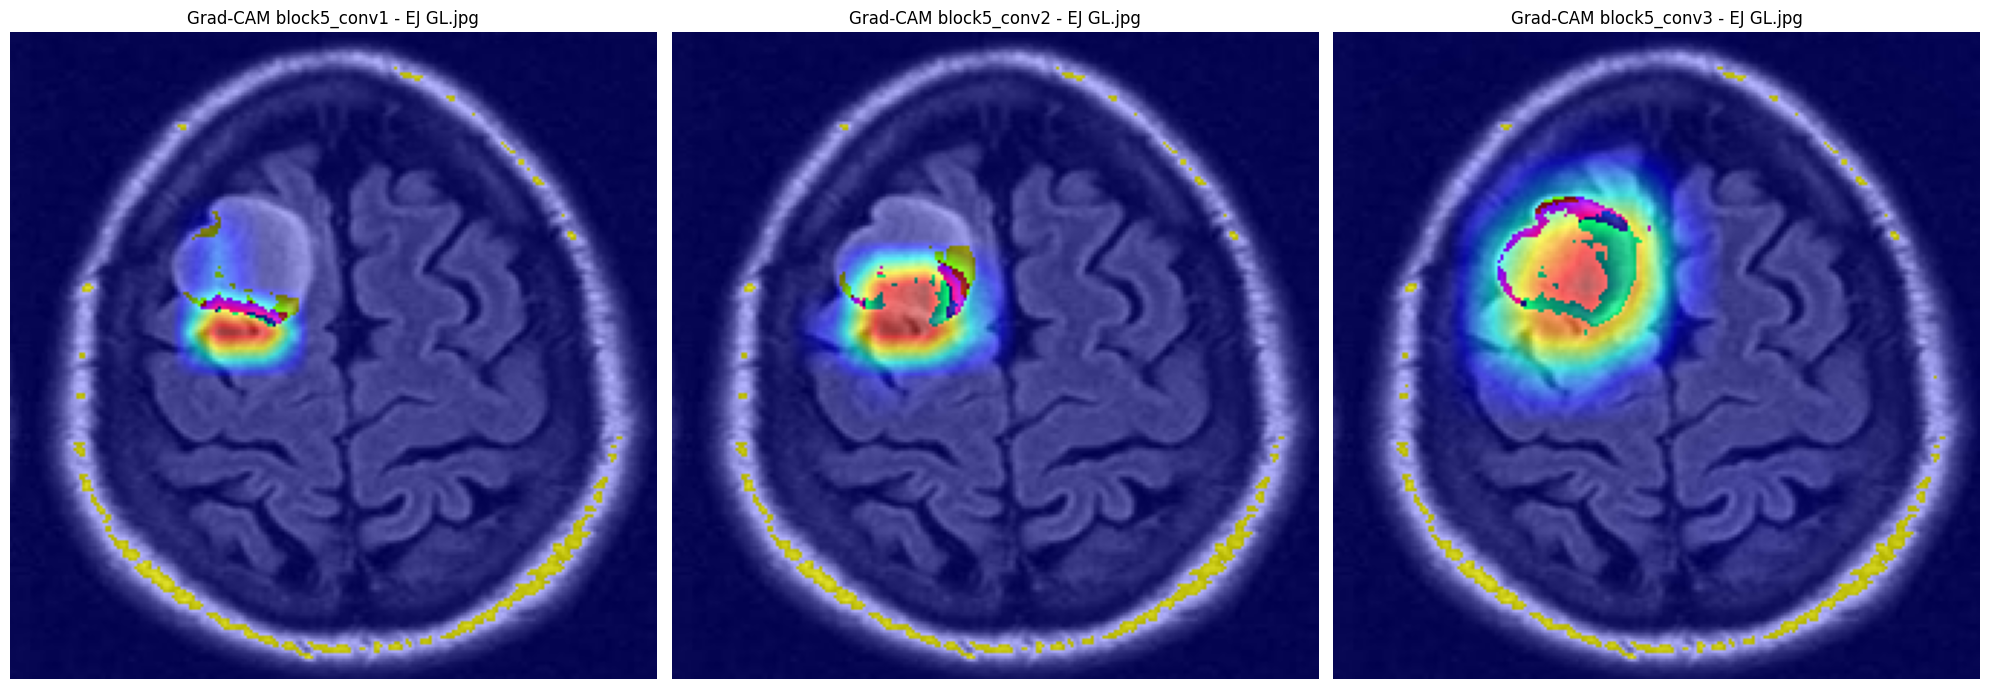

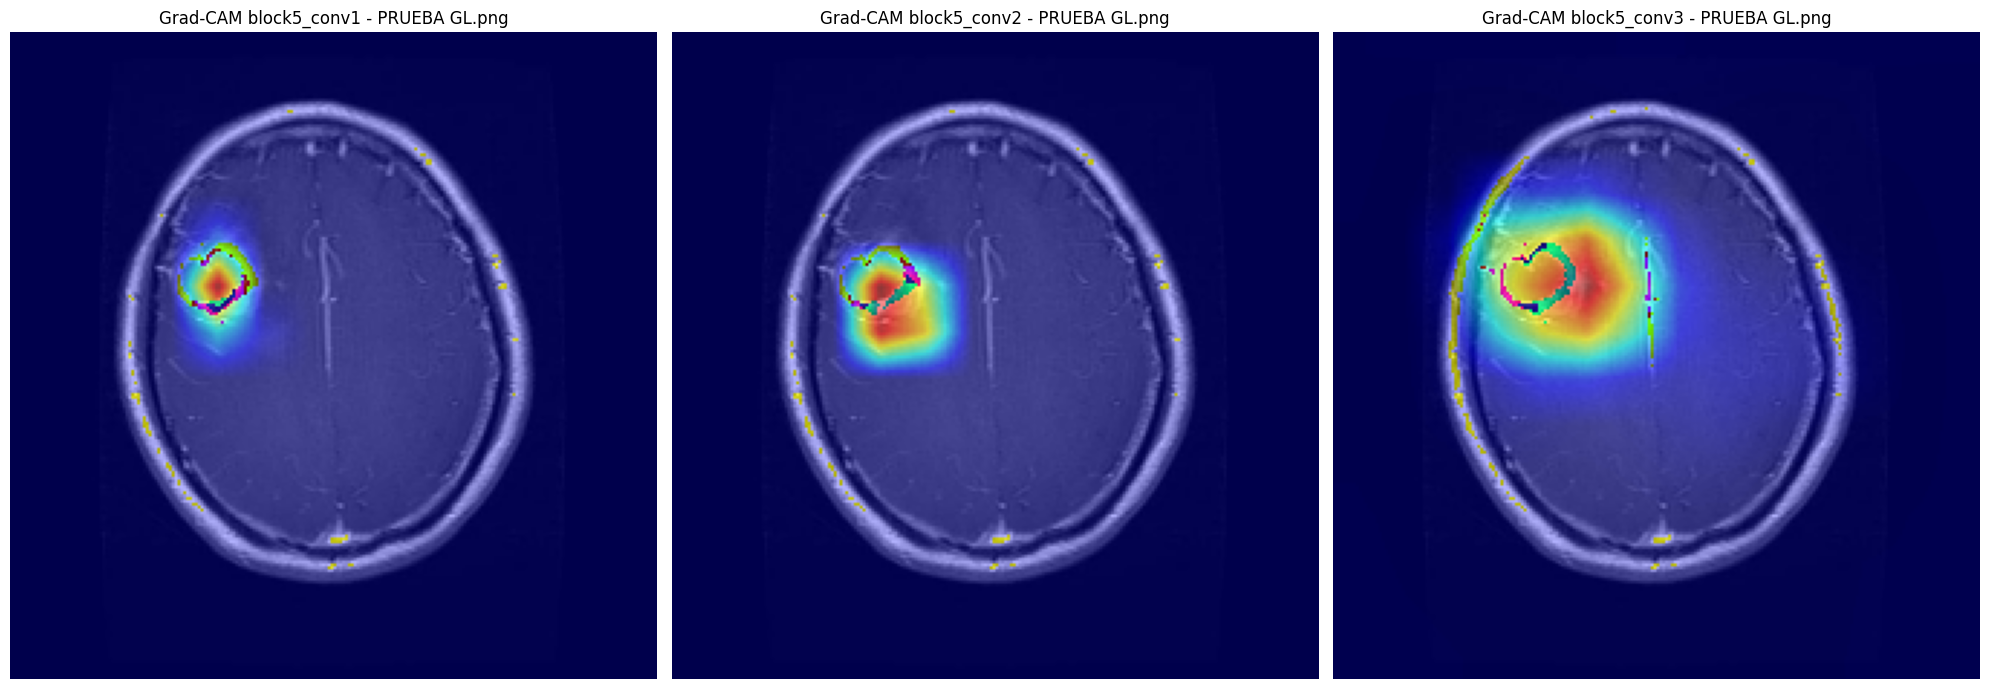

In [ ]:
# Para Modelo VGG16
for img_array, img_name in images:
    plt.figure(figsize=(20, 10))
    for i, layer_name in enumerate(layer_names_model):
        heatmap = get_gradcam(model, img_array, layer_name)
        superimposed_img = display_gradcam(img_array, heatmap)
        plt.subplot(1, len(layer_names_model), i+1)
        plt.title(f'Grad-CAM {layer_name} - {img_name}')
        plt.imshow(superimposed_img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
def analyze_errors(model, test_generator):
    # Reiniciar el generador de datos
    test_generator.reset()

    # Obtener las probabilidades de las predicciones
    y_pred_prob = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

    # Aplanar las predicciones y etiquetas verdaderas
    y_pred = y_pred_prob.argmax(axis=-1)
    y_test = test_generator.classes

    results = pd.DataFrame({
        'Etiqueta Actual': y_test,
        'Etiqueta Predicha': y_pred
    })

    # Convertir etiquetas numéricas a categorías para mejor visualización
    results['Etiqueta Actual'] = results['Etiqueta Actual'].map({0: 'Healthy', 1: 'Tumor'})
    results['Etiqueta Predicha'] = results['Etiqueta Predicha'].map({0: 'Healthy', 1: 'Tumor'})

    # Identificar predicciones incorrectas
    incorrect_predictions = results[results['Etiqueta Actual'] != results['Etiqueta Predicha']]

    # Contar errores específicos
    count_tumor_predicted_as_healthy = len(incorrect_predictions[
        (incorrect_predictions['Etiqueta Actual'] == 'Tumor') &
        (incorrect_predictions['Etiqueta Predicha'] == 'Healthy')
    ])

    count_healthy_predicted_as_tumor = len(incorrect_predictions[
        (incorrect_predictions['Etiqueta Actual'] == 'Healthy') &
        (incorrect_predictions['Etiqueta Predicha'] == 'Tumor')
    ])

    # Mostrar resultados generales
    print("Número de predicciones incorrectas:", len(incorrect_predictions))
    print(incorrect_predictions)
    print("\n")

    # Mostrar errores específicos
    print("Errores específicos:")
    print("Tumor predicho como Healthy:", count_tumor_predicted_as_healthy)
    print("Healthy predicho como Tumor:", count_healthy_predicted_as_tumor)
    print("\n")

In [ ]:
print("Errores en Modelo VGG16 Fine Tunning:")
analyze_errors(model, test_generator)

Errores en Modelo VGG16 Fine Tunning:
238/238 [==============================] - 19s 80ms/step
Número de predicciones incorrectas: 6
     Etiqueta Actual Etiqueta Predicha
1929           Tumor           Healthy
2259           Tumor           Healthy
2743           Tumor           Healthy
3406           Tumor           Healthy
3614           Tumor           Healthy
3775           Tumor           Healthy


Errores específicos:
Tumor predicho como Healthy: 6
Healthy predicho como Tumor: 0


